In [1]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

In [2]:
#Importar todos os arquivos do dataset e criar um dataframe único com todas as informações:

meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')

base_airbnb_df = pd.DataFrame()

dataframes = []

for arquivo in caminho_bases.iterdir():
    mes = meses[arquivo.name[:3]]
    ano = int((arquivo.name[-8:]).replace('.csv', ''))
    
    df = pd.read_csv(caminho_bases / arquivo.name, low_memory=False)
    df['ano'] = ano
    df['mes'] = mes
    
    dataframes.append(df)

base_airbnb_df = pd.concat(dataframes)
display(base_airbnb_df)

id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

Limpeza do dataframe:
- Como existem muitas colunas no dataframe final, o modelo pode acabar ficando muito lento. Além disso, em uma análise rápida, é possível identificar que várias colunas não são necessárias para o modelo de previsão. Por isso, iremos excluir algumas colunas do dataframe.
- Procedimento: Criar um arquivo em excel com os 1000 primeiros registros e fazer uma análise qualitativa.
- Colunas que serão excluídas:
    - IDs e Links - Informações não relevantes
    - Datas em que as informações foram obtidas - Informações já disponíveis nas colunas mês e ano.
    - Colunas com texto livre (Como nome, resumo, descrição do espaço, etc.) - Não será feita nenhuma análise dessas palavras ou termos descritivos no modelo.
    - Colunas em que todos ou quase todos os valores são iguais ou vazios.
    - Informações irrelevantes sobre o host (Como tempo de resposta, localização do host, tempo como host, etc.) - Irrelevantes para o modelo proposto.
    - Colunas com informações repetidas - Rua, Bairro, Estado, etc. não precisam ser mantidas pois temos uma coluna com longitude e latitude que já nos permite obter essas informações.
    - Preços semanais e mensais - O modelo é para calcular preços diários.

In [ ]:
#Criar arquivo csv para limpeza inicial:
base_airbnb_df.head(1000).to_csv('primeiros_registros.csv', sep=';')

In [3]:
#Após análise e limpeza inicial obtivemos as seguintes colunas:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb_df = base_airbnb_df.loc[:,colunas]

display(base_airbnb_df)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

Tratar valores vazios:

- Analisando os dados, percebe-se que há uma grande quantidade de dados em falta(vazios). Por conta disso, colunas com mais de 300 mil valores NaN foram excluídas da análise.
- Para as outras colunas com dados NaN, iremos apenas excluir as linhas que os contém, tendo em conta que ainda há um grande volume de dados preenchidos que poderão contribuir para a análise.

In [4]:
#Verificando dados faltando:
base_airbnb_df.isnull().sum()

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [5]:
#Excluindo colunas com mais de 300 mil valores vazios:
for coluna in base_airbnb_df:
    if base_airbnb_df[coluna].isnull().sum() > 300000:
        base_airbnb_df = base_airbnb_df.drop(coluna, axis=1)

In [6]:
#Excluindo linhas vazias:
base_airbnb_df = base_airbnb_df.dropna()

Verificar e tratar os tipos de dados em cada coluna:

In [7]:
print(base_airbnb_df.dtypes)
print('-'*60)
print(base_airbnb_df.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

In [8]:
#Atualizar as colunas price e extra_people para que sejam reconhecidas como números:
base_airbnb_df[['price', 'extra_people']] = base_airbnb_df[['price', 'extra_people']].apply(lambda x: x.str.replace('$', '', regex=True).str.replace(',', '').astype(np.float32, copy=False))

Análise Exploratória e Tratar Outliers:

- Verificar a correlação entre as features e decidir quais serão mantidas.

- Excluir outliers:
    - Regra:
        - Amplitude = Q3 - Q1
        - Valores abaixo de (Q1 - 1.5 x Amplitude)
        - Valores acima de (Q3 + 1.5 x Amplitude)
<br></br>        
- Confirmar se as features realmente contribuirão com o modelo.

<AxesSubplot:>

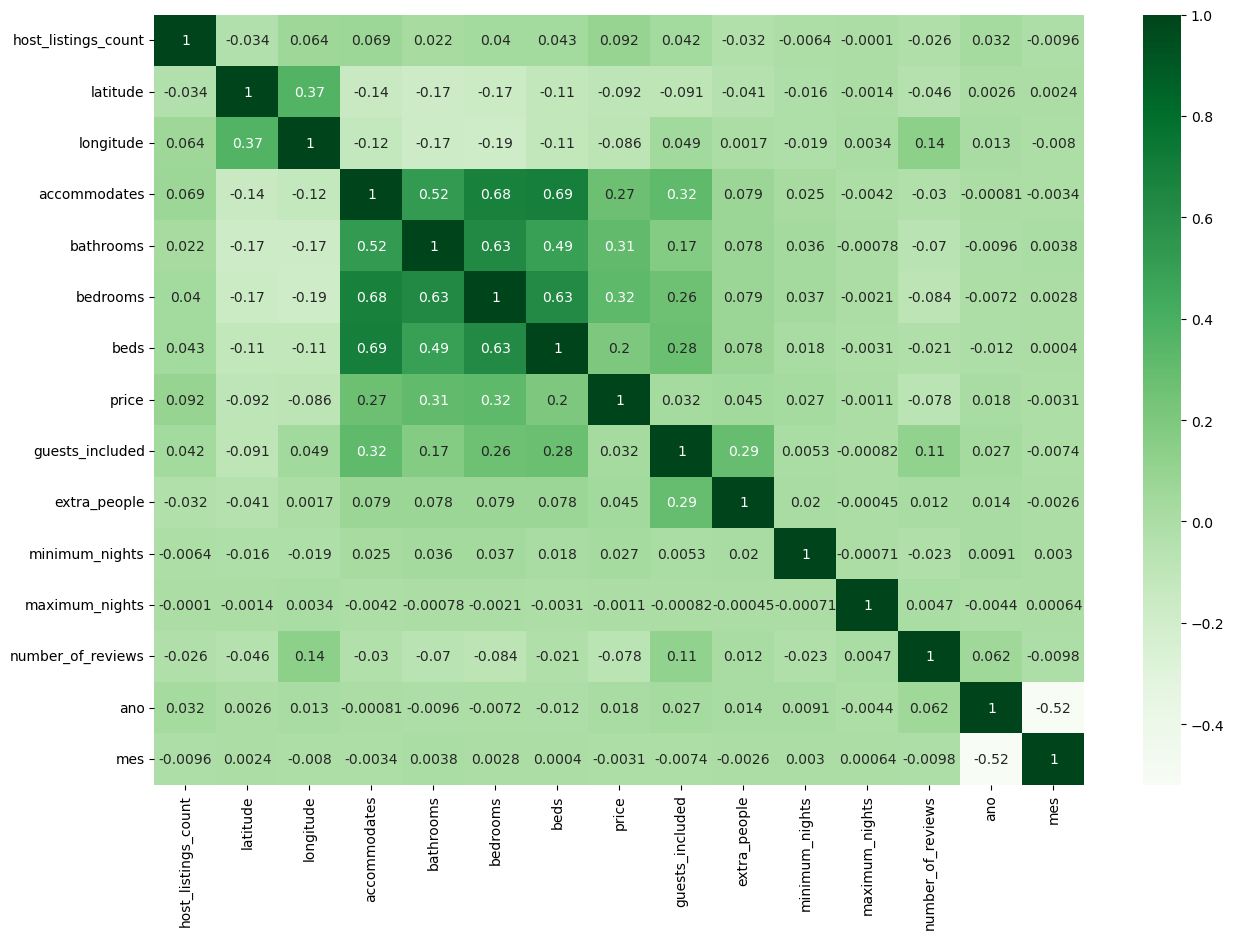

In [9]:
#Analisando a correlação entre as colunas:
plt.figure(figsize=(15,10))
sns.heatmap(base_airbnb_df.corr(), annot=True, cmap='Greens')

In [10]:
#Funções para ajudar na análise dos outliers das colunas:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

#Funções para construir os gráficos:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)

def grafico_barra(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

d:\Users\diego\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


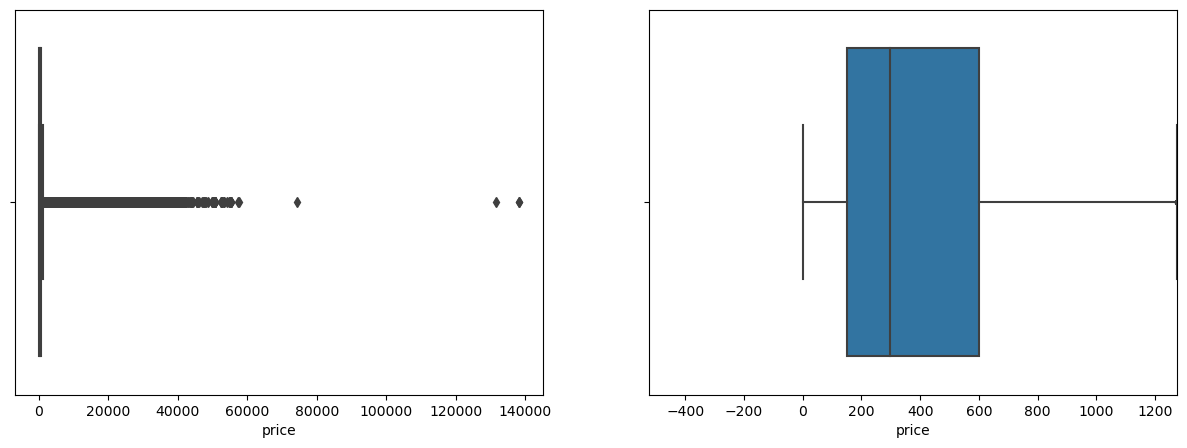

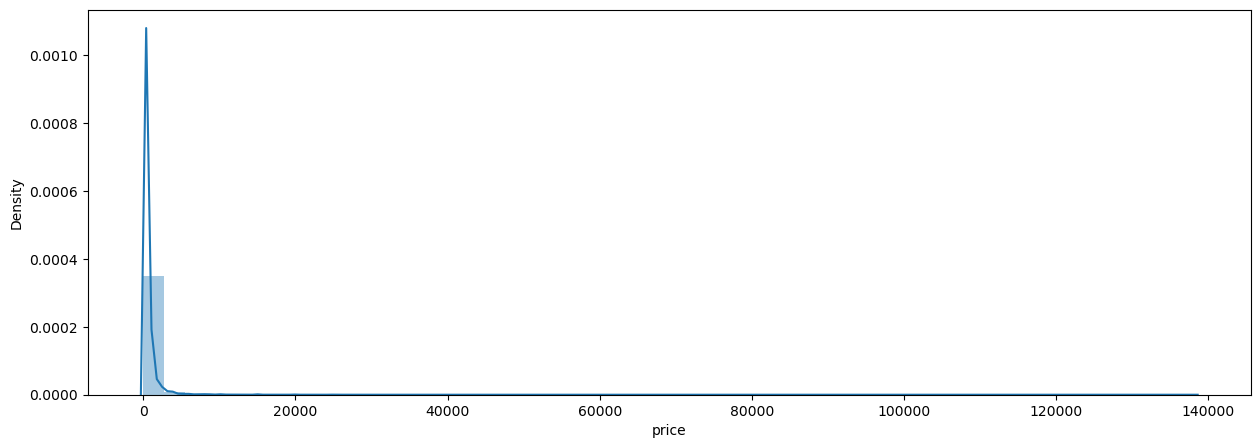

In [11]:
#price:
diagrama_caixa(base_airbnb_df['price'])
histograma(base_airbnb_df['price'])

In [12]:
#Como o modelo que está sendo construído é para imóveis comuns, os valores acima do limite superior devem ser apenas de imóveis de altíssimo luxo, que não condiz com o objetivo principal do modelo. Por isso esses outliers serão excluídos.

base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'price')
print(f'{linhas_removidas} linhas removidas.')

87282 linhas removidas.


d:\Users\diego\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


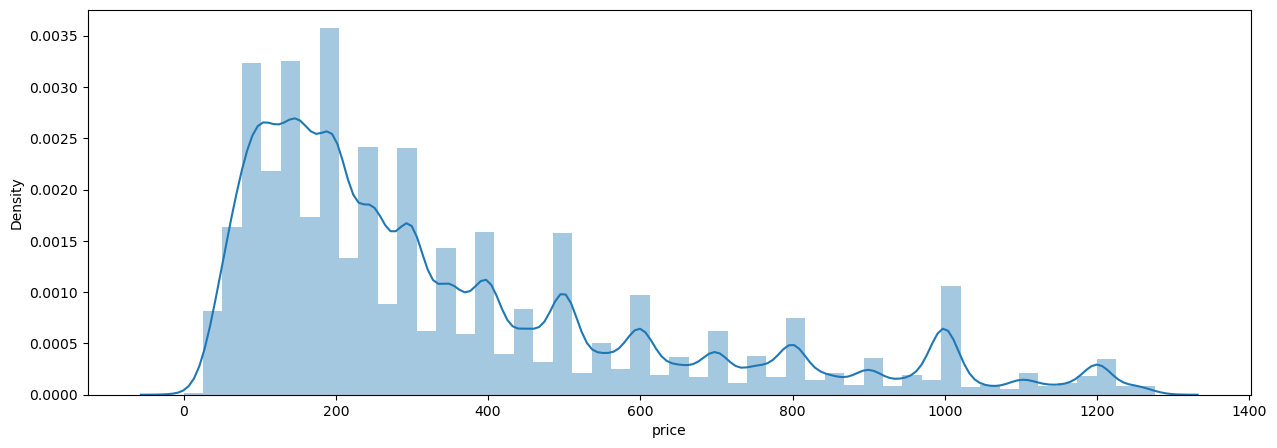

In [13]:
histograma(base_airbnb_df['price'])

d:\Users\diego\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


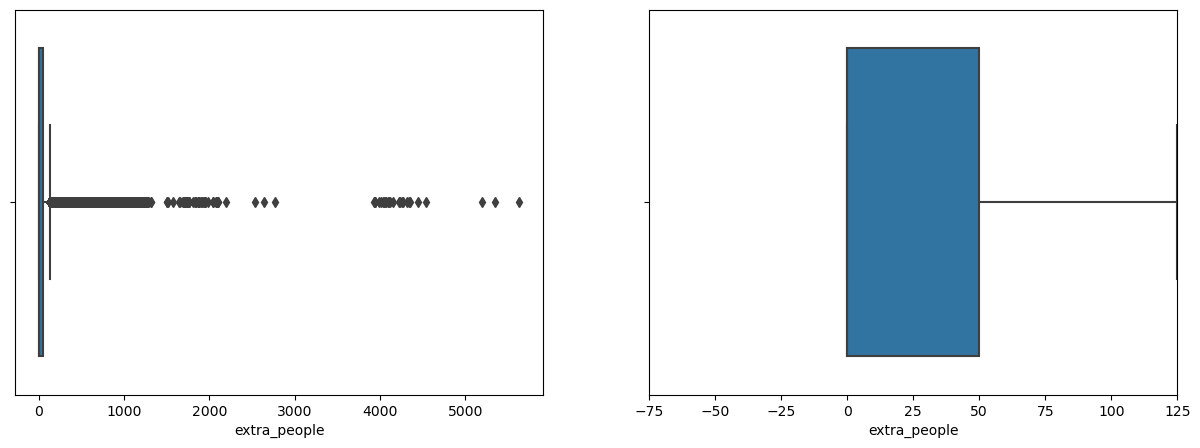

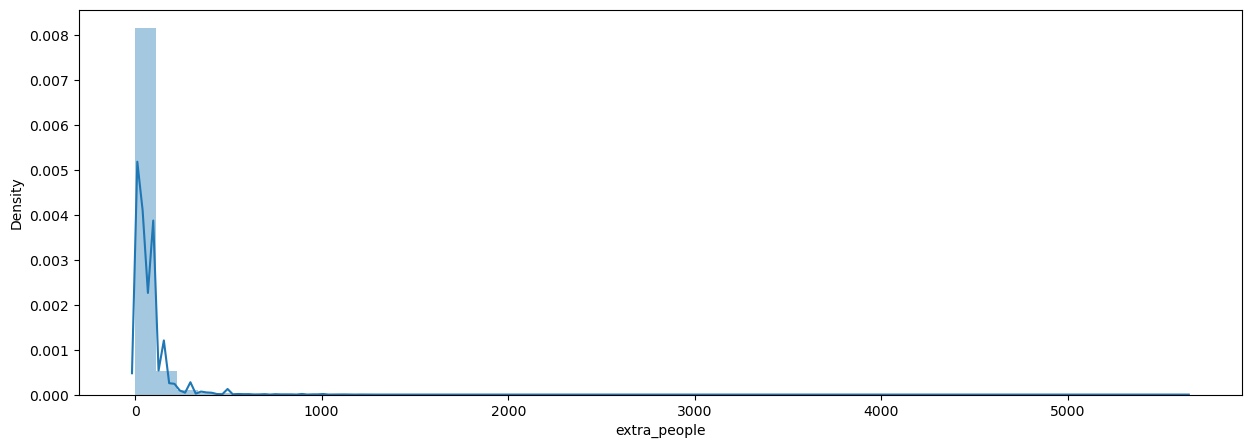

In [14]:
#extra_people:
diagrama_caixa(base_airbnb_df['extra_people'])
histograma(base_airbnb_df['extra_people'])

In [15]:
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'extra_people')
print(f'{linhas_removidas} linhas removidas.')

59194 linhas removidas.


d:\Users\diego\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


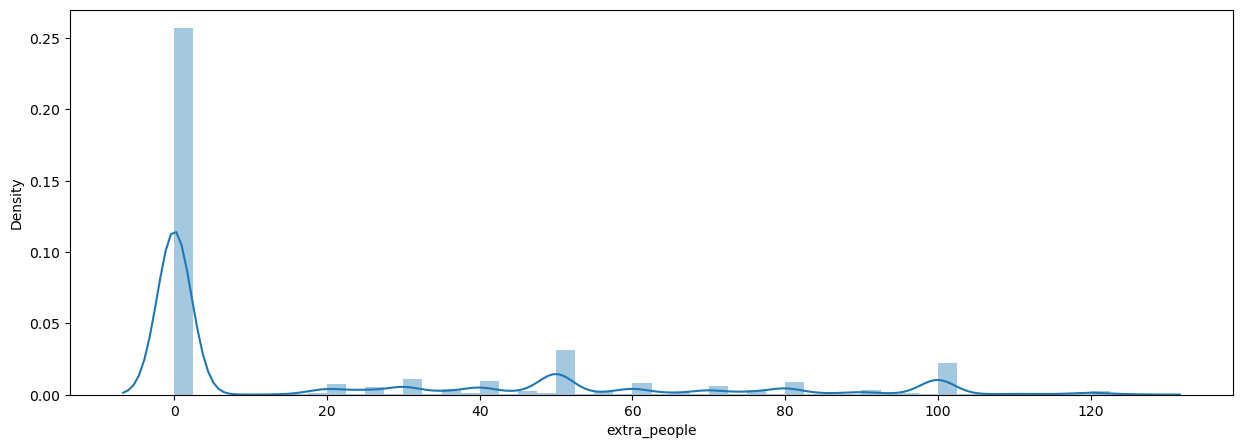

In [16]:
histograma(base_airbnb_df['extra_people'])

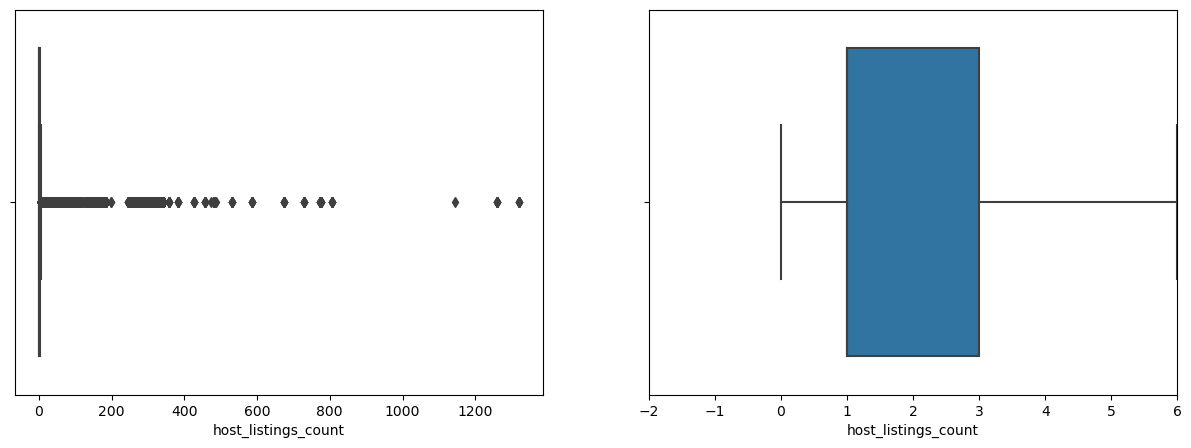

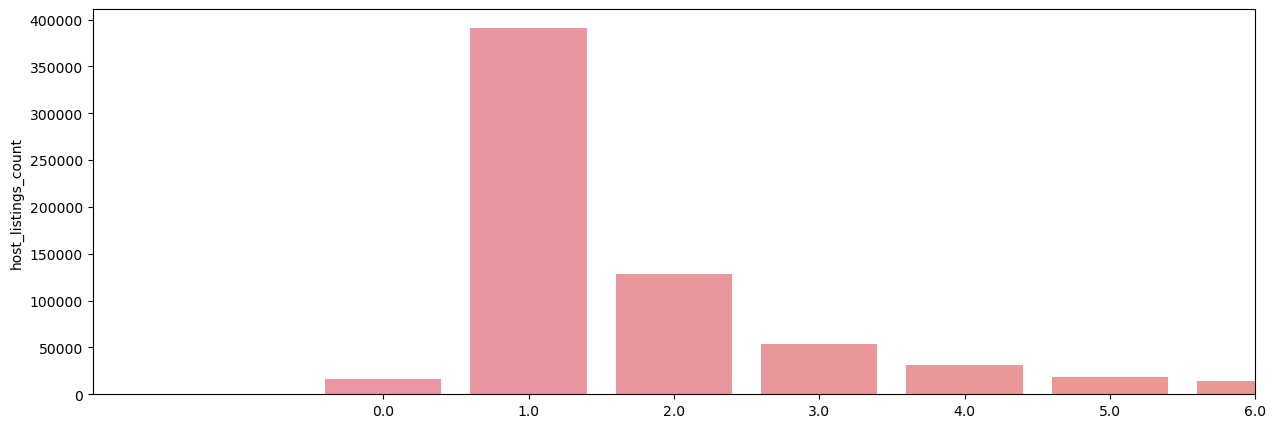

In [17]:
#host_listing_count:

diagrama_caixa(base_airbnb_df['host_listings_count'])
grafico_barra(base_airbnb_df['host_listings_count'])

In [18]:
#Como o modelo que está sendo construído é para imóveis de proprietários comuns, hosts com mais de 6 imóveis devem pertencer a imobiliárias ou profissionais que gerenciam imóveis no airbnb. Por isso esses outliers serão excluídos.

base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'host_listings_count')
print(f'{linhas_removidas} linhas removidas.')

97723 linhas removidas.


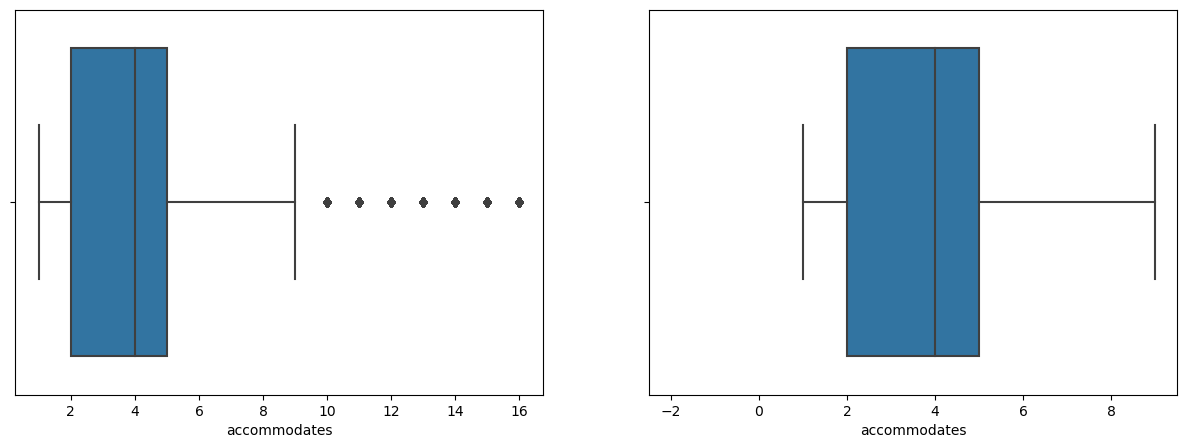

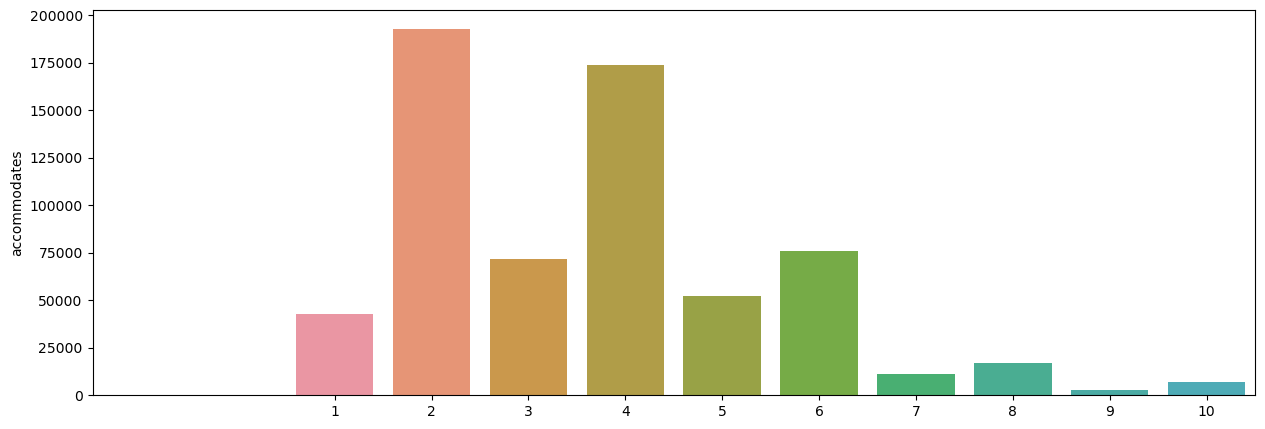

In [19]:
#accommodates:

diagrama_caixa(base_airbnb_df['accommodates'])
grafico_barra(base_airbnb_df['accommodates'])

In [20]:
#Excluindo da análise casas que fujam do "padrão comum", assim como os "host_listing_count". Presume-se que um imóvel que acomode mais de 9 pessoas fuja do foco e do objetivo de analisar hospedagens comuns.

base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'accommodates')
print(f'{linhas_removidas} linhas removidas.')

13146 linhas removidas.


<AxesSubplot:ylabel='bathrooms'>

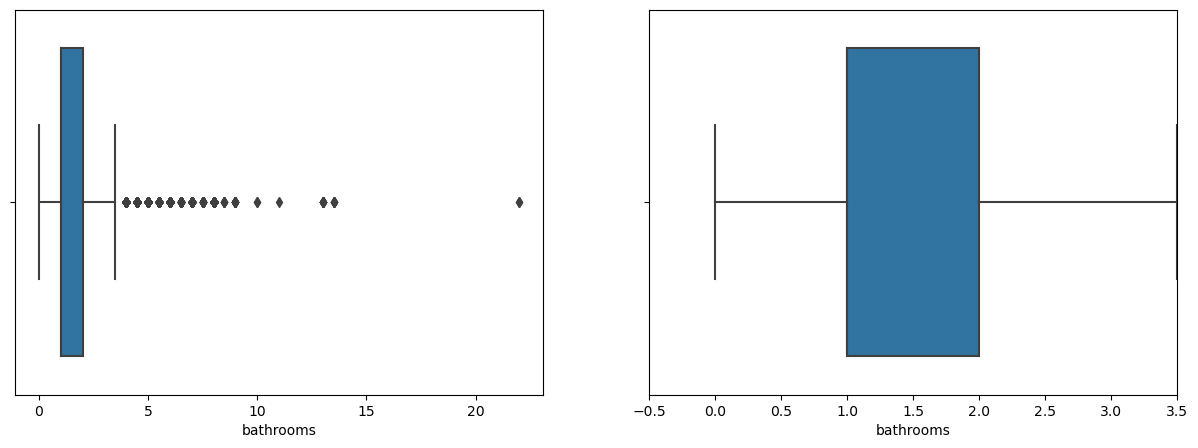

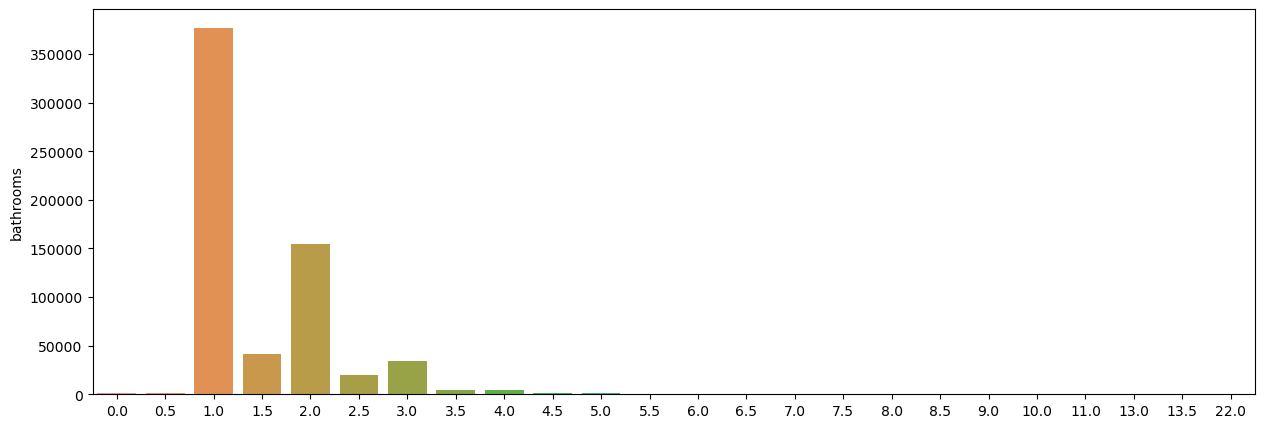

In [21]:
#bathrooms:

diagrama_caixa(base_airbnb_df['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb_df['bathrooms'].value_counts().index, y=base_airbnb_df['bathrooms'].value_counts())

In [22]:
#Excluindo da análise casas que fujam do "padrão comum"

base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'bathrooms')
print(f'{linhas_removidas} linhas removidas.')

6894 linhas removidas.


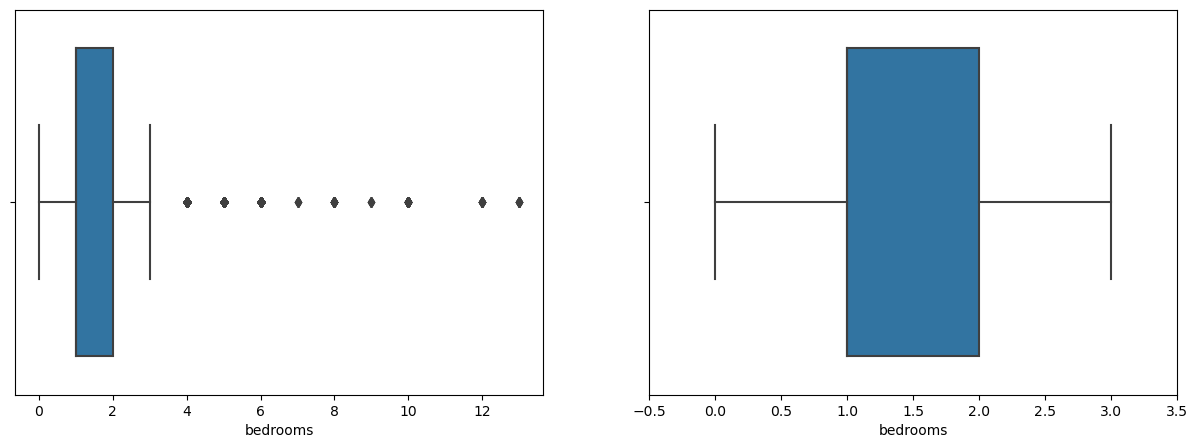

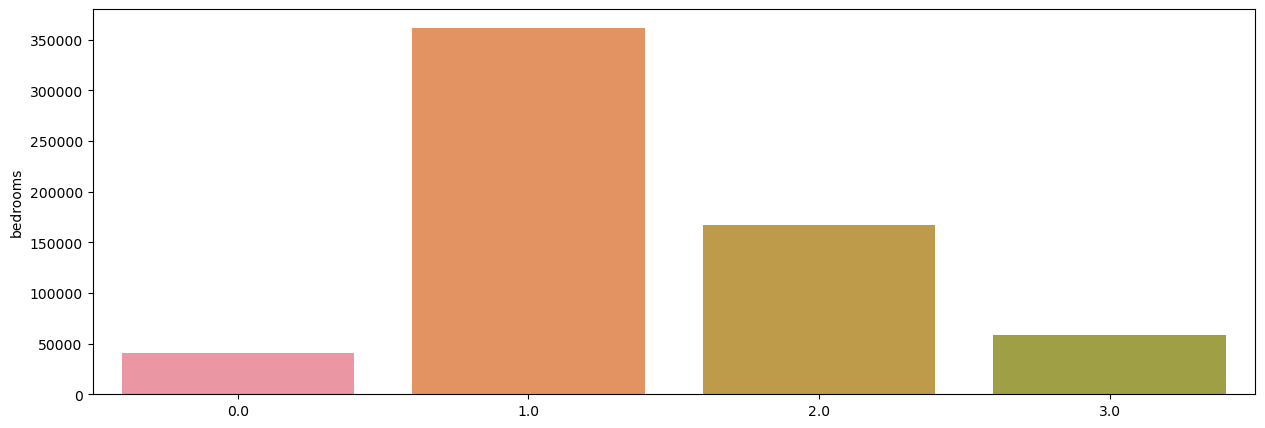

In [23]:
#bedroms
diagrama_caixa(base_airbnb_df['bedrooms'])
grafico_barra(base_airbnb_df['bedrooms'])

In [24]:
#Excluindo da análise casas que fujam do "padrão comum":
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'bedrooms')
print(f'{linhas_removidas} linhas removidas')

5482 linhas removidas


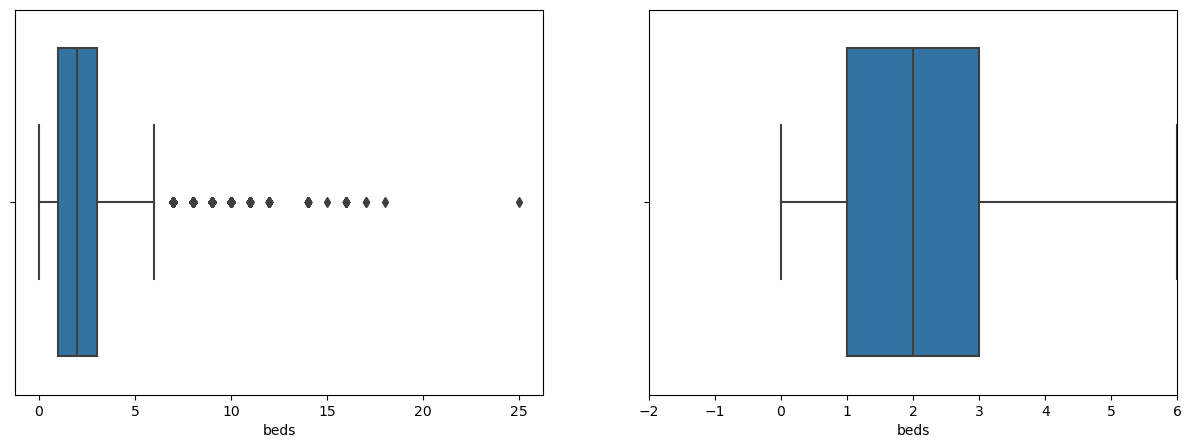

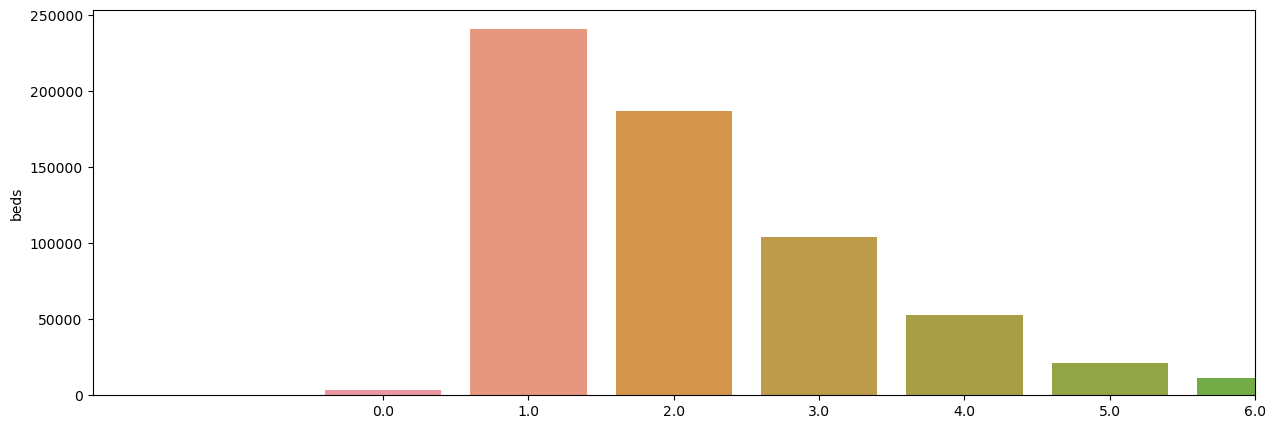

In [25]:
#beds:
diagrama_caixa(base_airbnb_df['beds'])
grafico_barra(base_airbnb_df['beds'])

In [26]:
#Excluindo da análise casas que fujam do "padrão comum":
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'beds')
print(f'{linhas_removidas} linhas removidas')

5622 linhas removidas


<AxesSubplot:ylabel='guests_included'>

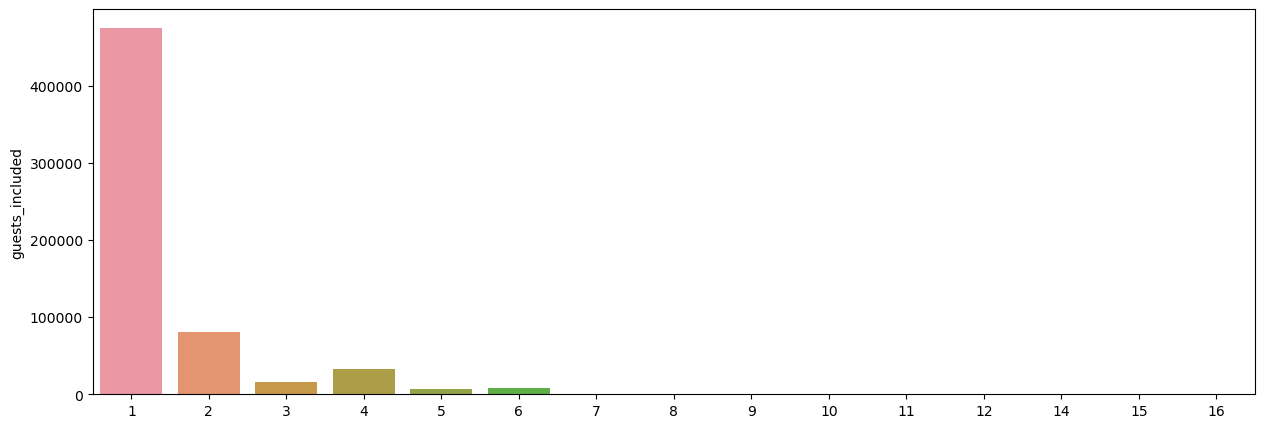

In [27]:
#guest_included:
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb_df['guests_included'].value_counts().index, y=base_airbnb_df['guests_included'].value_counts())

In [28]:
#Excluindo essa coluna da análise pois parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o modelo a considerar uma feature que na verdade não é essencial para a definição do preço.
base_airbnb_df = base_airbnb_df.drop('guests_included', axis=1)

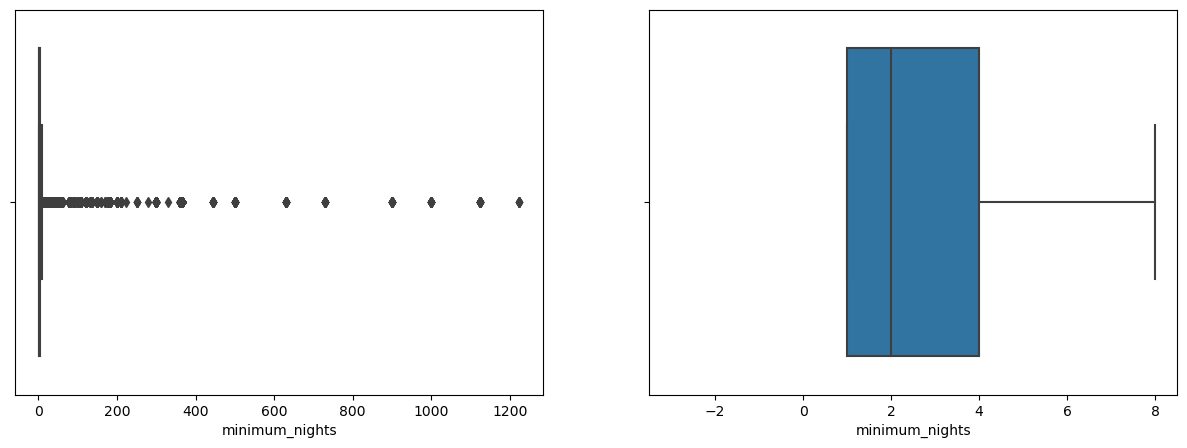

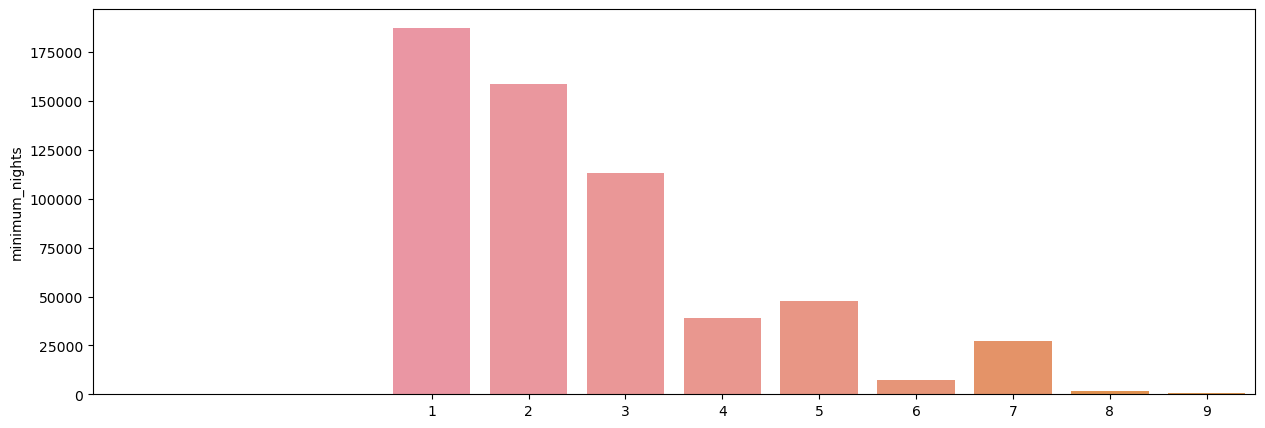

In [29]:
#minimun_nights:
diagrama_caixa(base_airbnb_df['minimum_nights'])
grafico_barra(base_airbnb_df['minimum_nights'])

In [30]:
#Excluindo os outliers dessa coluna porque imóveis com mais de 8 noites como o "mínimo de noites" podem ser de temporada ou ainda imóveis para moradia, em que o host exige pelo menos 1 mês no apartamento. Não condizendo com a análise que queremos desenvolver no modelo.

base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'minimum_nights')
print(f'{linhas_removidas} linhas removidas')

40383 linhas removidas


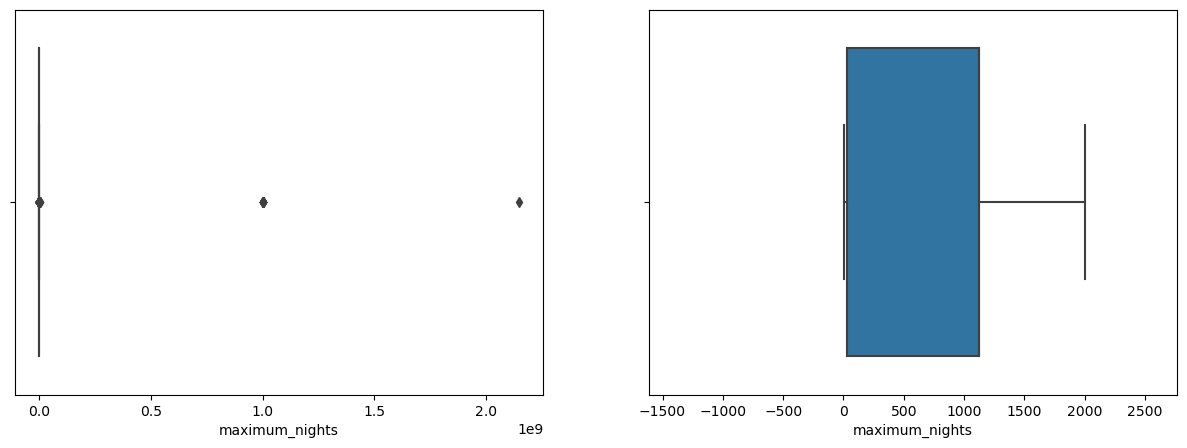

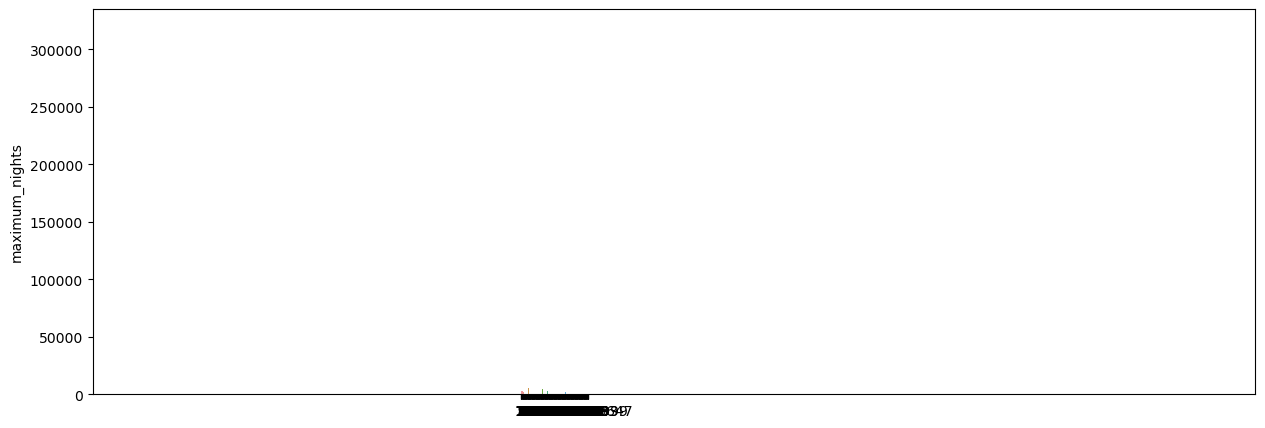

In [31]:
#maximum_nights:
diagrama_caixa(base_airbnb_df['maximum_nights'])
grafico_barra(base_airbnb_df['maximum_nights'])

In [32]:
#Excluindo essa coluna da análise pois parece que quase todos os hosts não preenchem esse campo, não contribuindo assim para a análise.
base_airbnb_df = base_airbnb_df.drop('maximum_nights', axis=1)

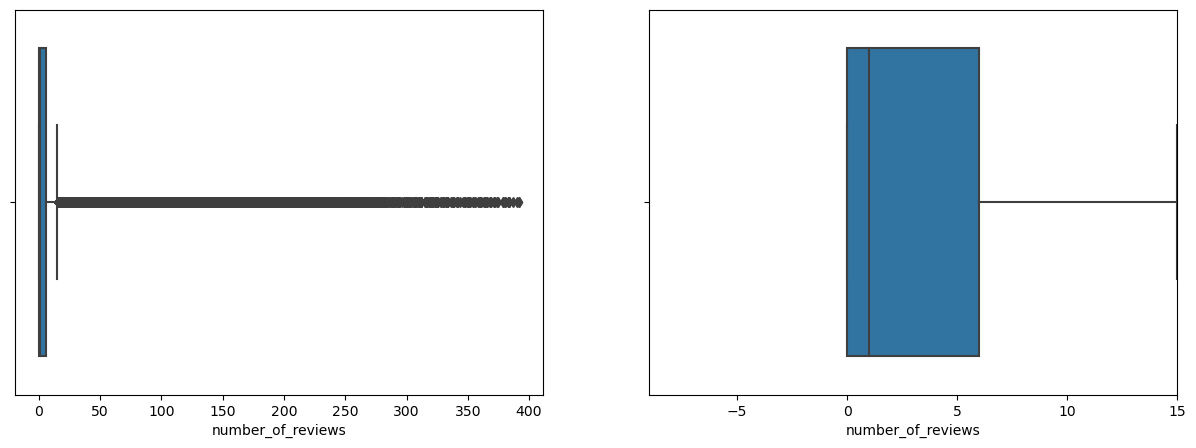

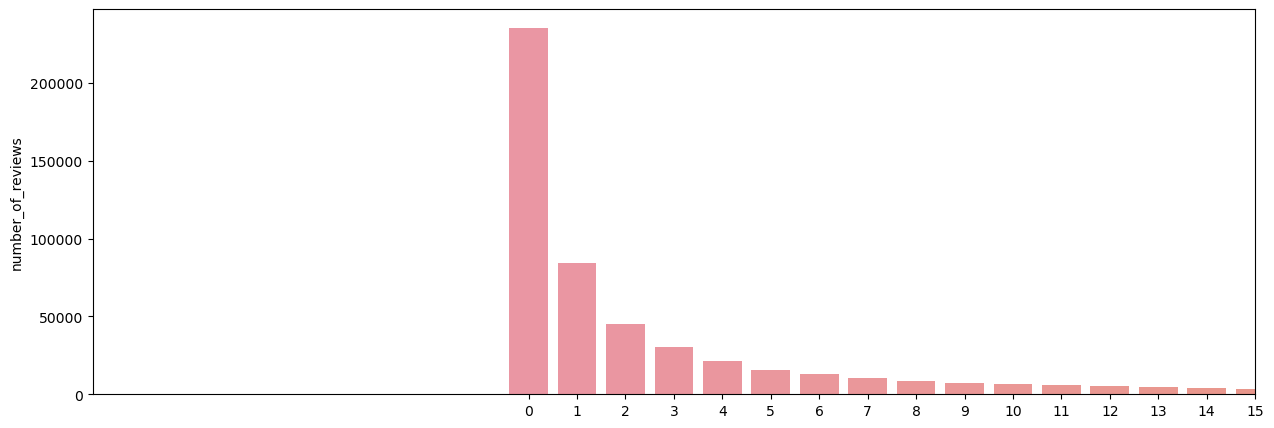

In [33]:
#number_of_reviews:
diagrama_caixa(base_airbnb_df['number_of_reviews'])
grafico_barra(base_airbnb_df['number_of_reviews'])

In [34]:
#Optei por remover essa característica da análise por alguns motivos:
    # Se excluir apenas os outliers, as pessoas que tem a maior quantidade de reviews (o que normalmente são os hosts que têm mais aluguel) serão excluídas da análise e isso pode impactar muito negativamente o modelo.
    #Pensando de acordo com o objetivo, se se eu tenho um imóvel parado e quero colocar meu imóvel disponível, eu não terei review nenhuma de início. Por isso, tirar essa característica da análise pode acabar ajudando.
    #Tenho dúvidas se essa característica deve impactar ou não no preço final.

base_airbnb_df = base_airbnb_df.drop('number_of_reviews', axis=1)

Tratamento de Colunas de Valores de Texto:

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

d:\Users\diego\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


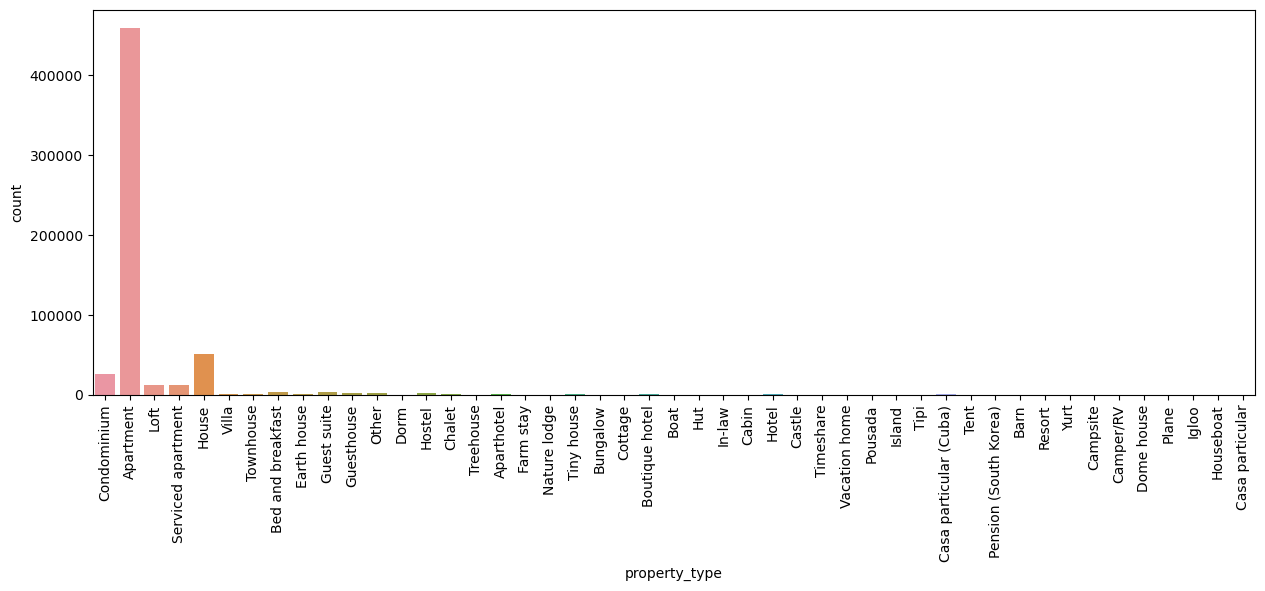

In [35]:
#property_type:

print(base_airbnb_df['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Others                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


d:\Users\diego\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


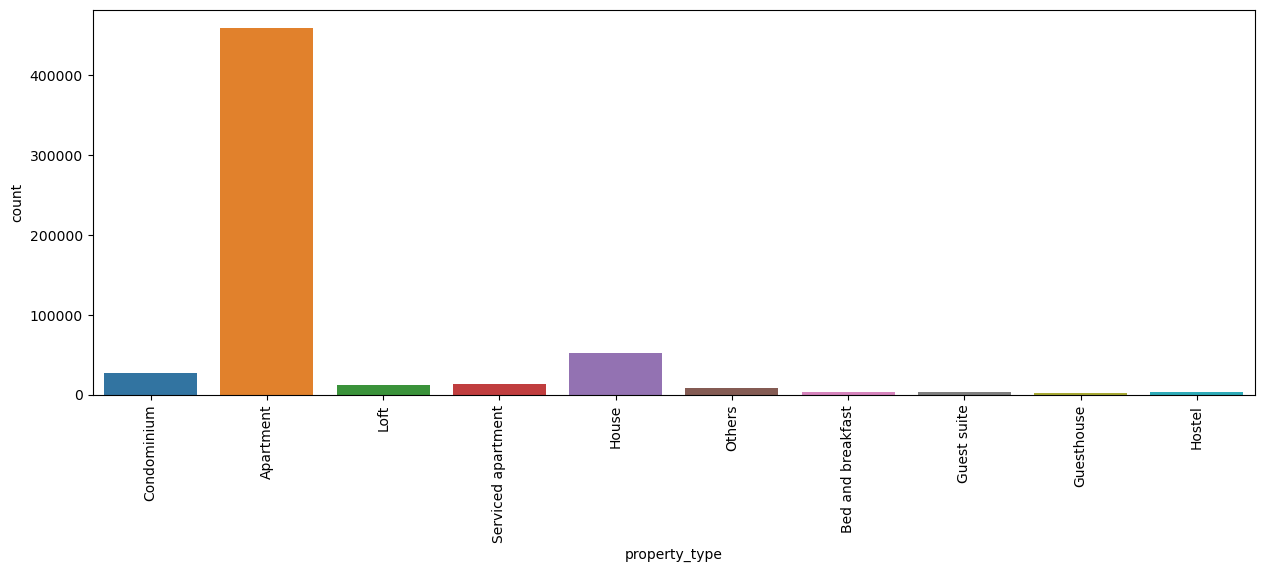

In [36]:
#Agrupar valores que são muito pequenos em um mesmo tipo de propriedade. Propriedades com menos de 2000 valores na base de dadas serão agrupadas dentro do grupo "others":

tabela_tipos_casa = base_airbnb_df['property_type'].value_counts()
colunas_agrupar = [tipo for tipo in tabela_tipos_casa.index if tabela_tipos_casa[tipo] < 2000]

for tipo in colunas_agrupar:
    base_airbnb_df.loc[base_airbnb_df['property_type']==tipo, 'property_type'] = 'Others'

print(base_airbnb_df['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


d:\Users\diego\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


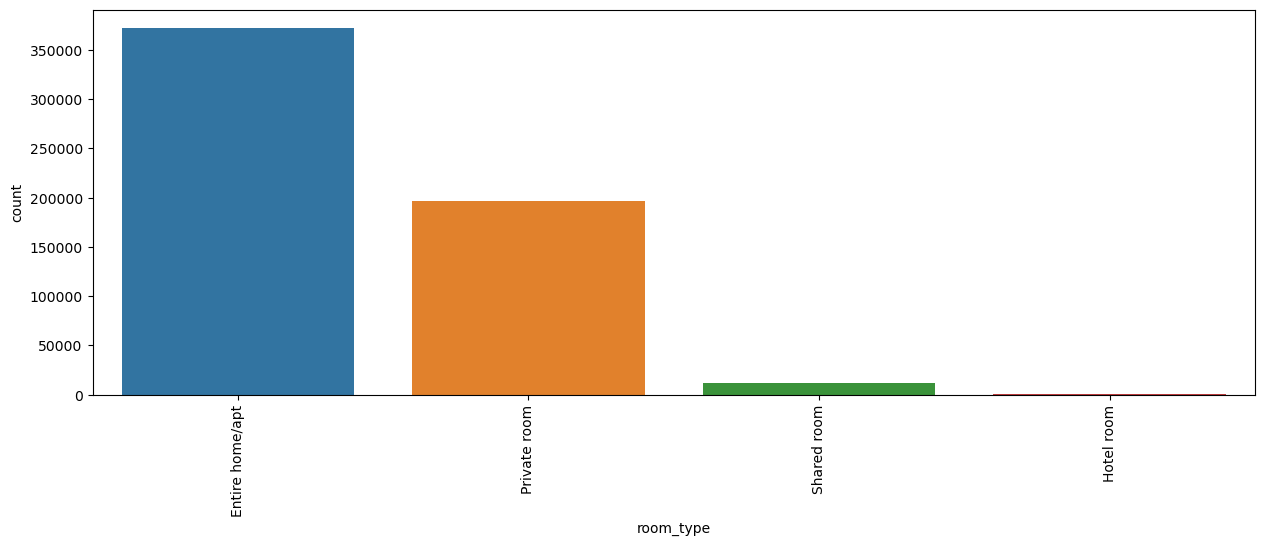

In [37]:
#room_type:
print(base_airbnb_df['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('room_type', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


d:\Users\diego\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


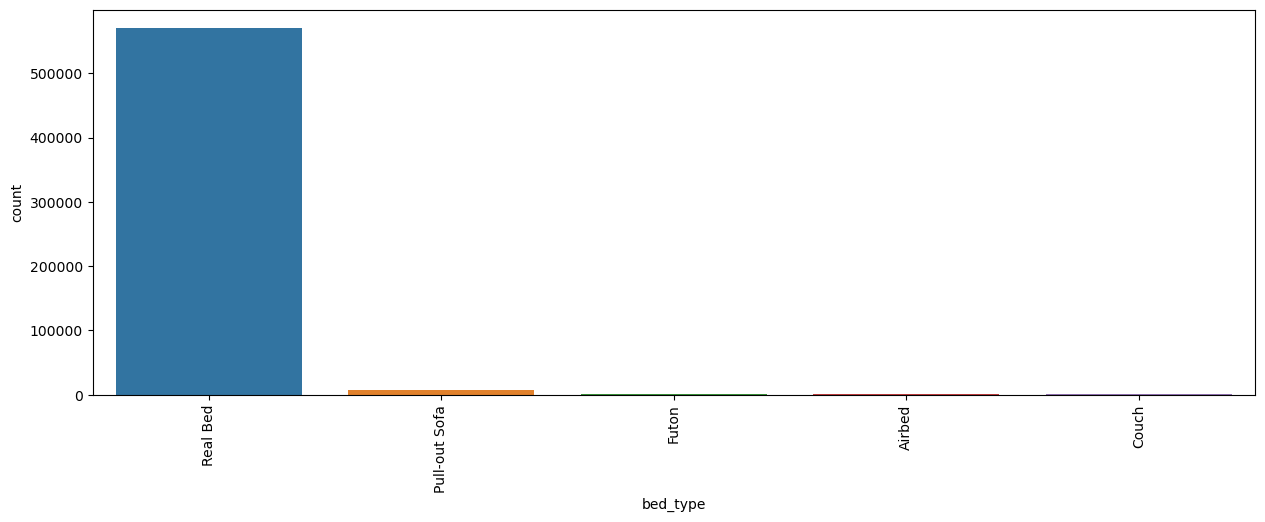

In [38]:
#bed_type:
print(base_airbnb_df['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

Real Bed    570643
Others       11340
Name: bed_type, dtype: int64


d:\Users\diego\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


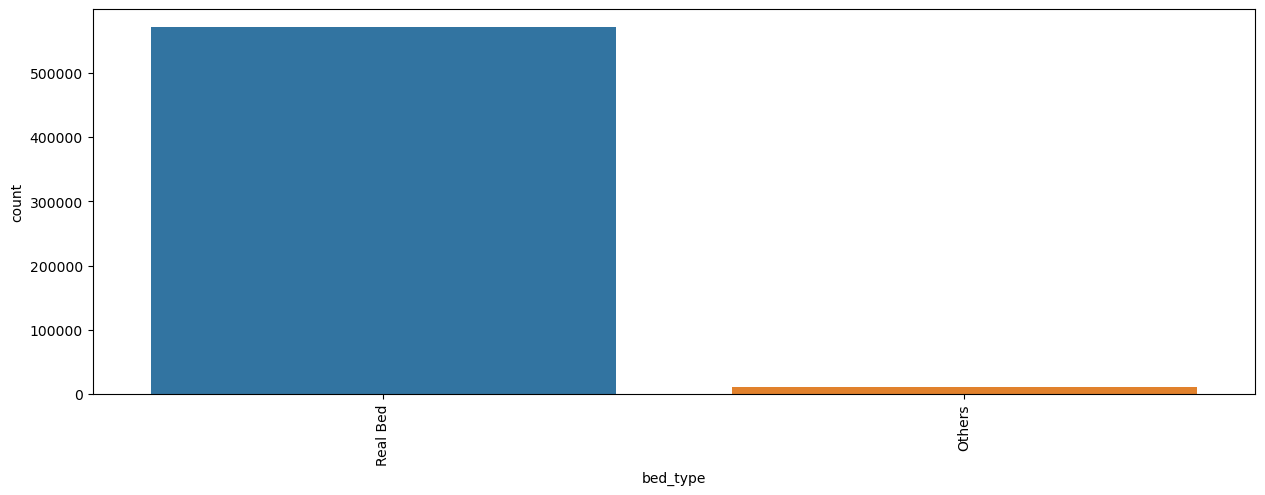

In [39]:
#Agrupando categorias de bed_type:
    #Agrupar valores que são muito pequenos em um único valor. Como há 1 valor muito maior do que todos os outros, todas as categorias fora de Real Bed serão agrupadas em Others para simplificar o modelo.

tabela_bed = base_airbnb_df['bed_type'].value_counts()
colunas_agrupar = [tipo for tipo in tabela_bed.index if tabela_bed[tipo] < 10000]

for tipo in colunas_agrupar:
    base_airbnb_df.loc[base_airbnb_df['bed_type']==tipo, 'bed_type'] = 'Others'

print(base_airbnb_df['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


d:\Users\diego\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


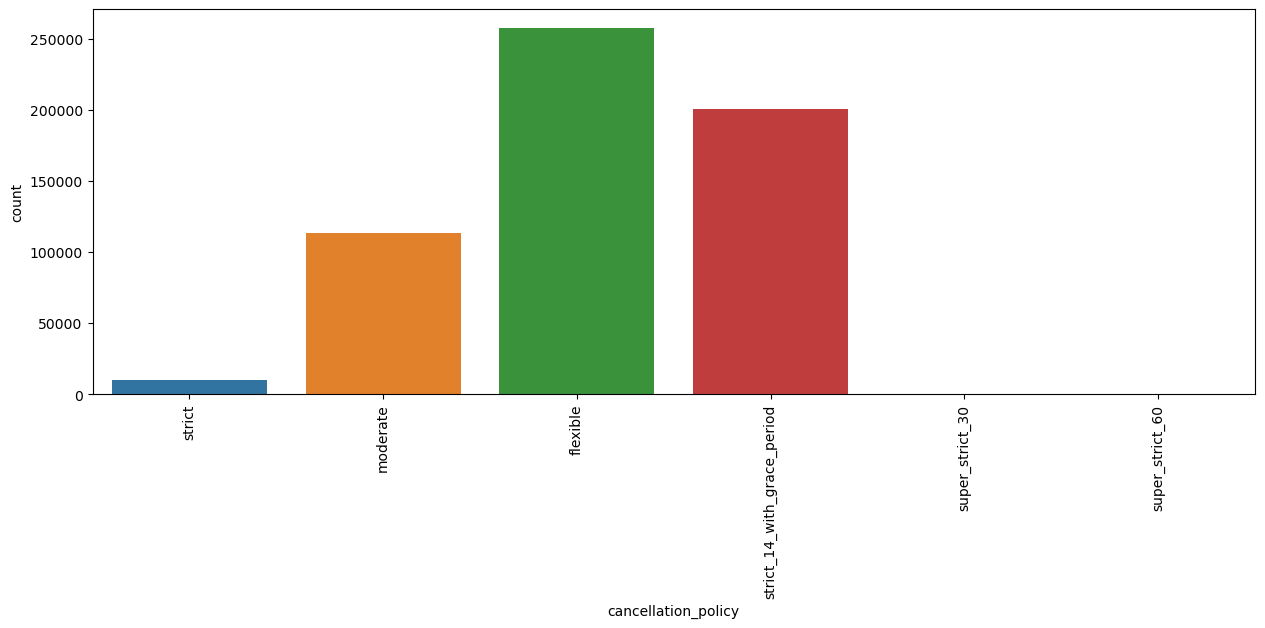

In [40]:
#cancellation_policy:
print(base_airbnb_df['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64


d:\Users\diego\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


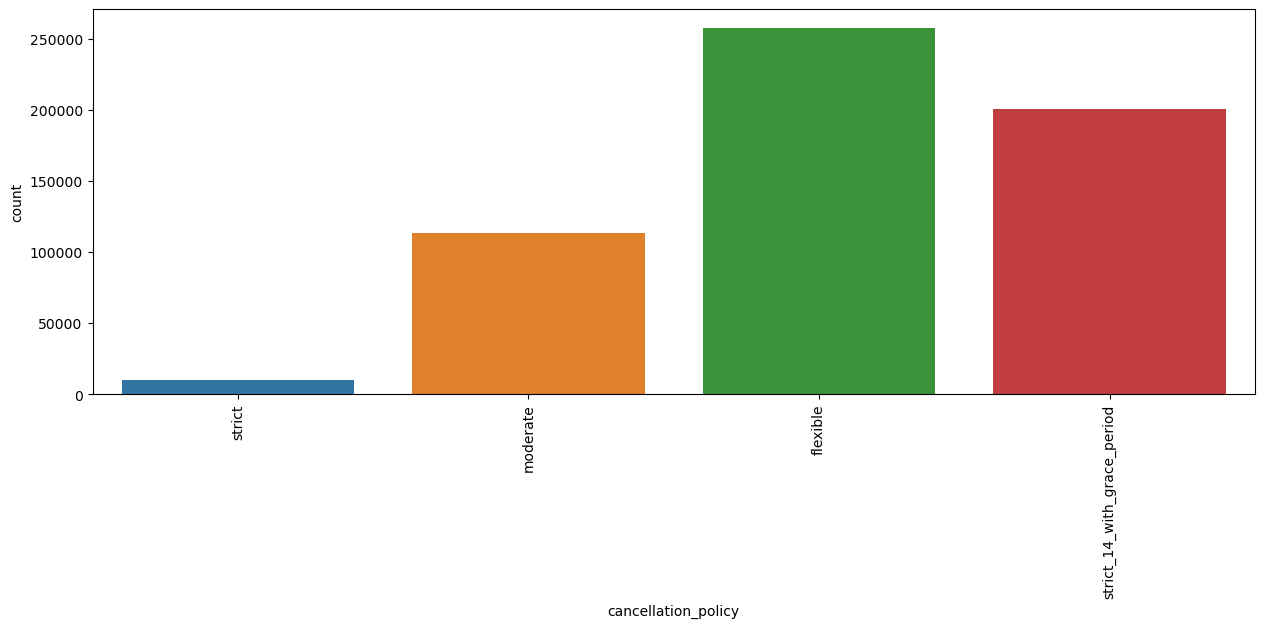

In [41]:
#Agrupar categorias de cancellation_pollicy
    #Simplificar o modelo agrupando as categoria de strict e super_strict em uma única devido aos poucos números de dados delas.
tabela_cancellation = base_airbnb_df['cancellation_policy'].value_counts()
colunas_agrupar = [tipo for tipo in tabela_cancellation.index if tabela_cancellation[tipo] < 10000]

for tipo in colunas_agrupar:
    base_airbnb_df.loc[base_airbnb_df['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb_df['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb_df)
grafico.tick_params(axis='x', rotation=90)

Amenities:
    Há uma diversidade muito grande de amenities, às vezes, as mesmas amenities escritas de forma diferente. 
    Para o modelo, ao invés de utilizar cada amenitie de forma individual, vamos avaliar a quantidade de amenities como parâmetro.

In [42]:
#Criar uma coluna com número de amenities e excluir a antiga coluna de amenities:
base_airbnb_df['n_amenities'] = base_airbnb_df['amenities'].str.split(',').apply(len)
base_airbnb_df = base_airbnb_df.drop('amenities', axis=1)

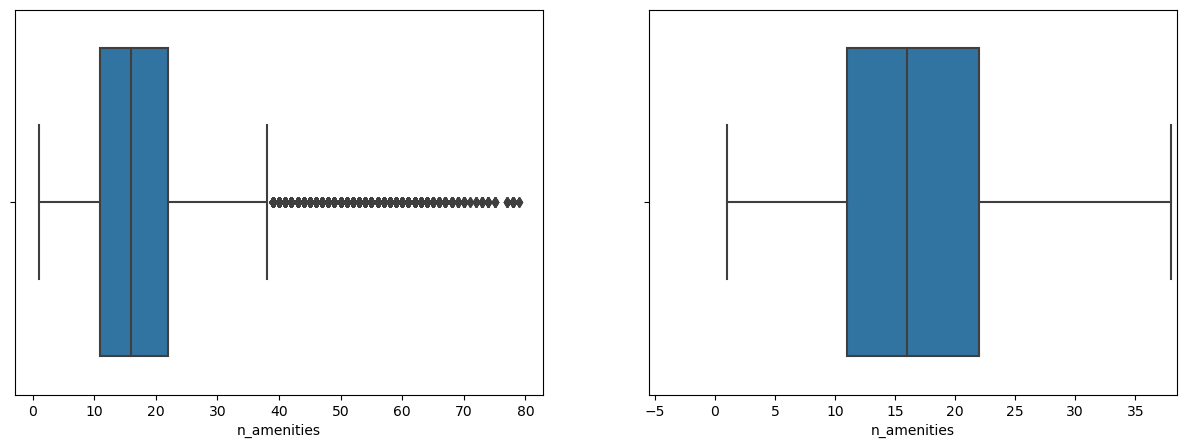

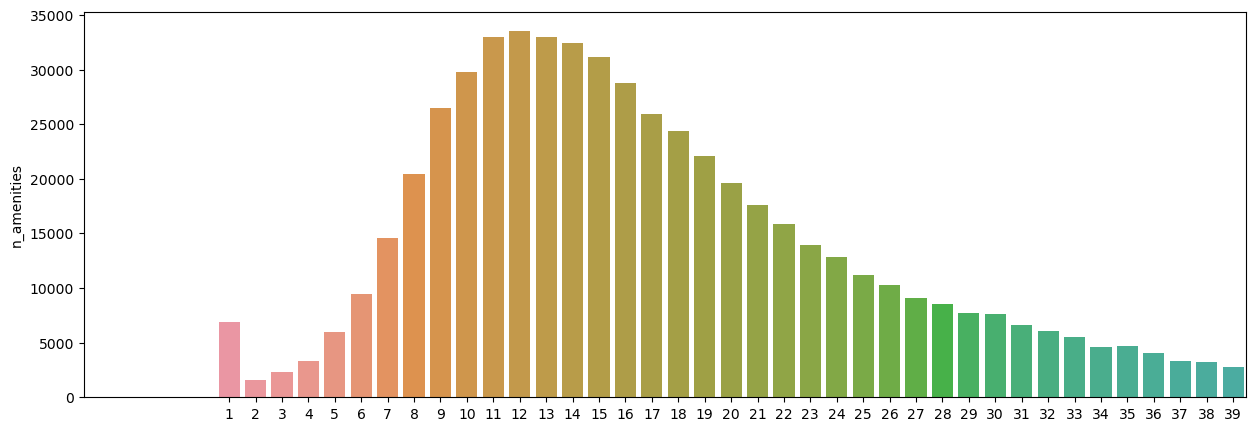

In [43]:
diagrama_caixa(base_airbnb_df['n_amenities'])
grafico_barra(base_airbnb_df['n_amenities'])

In [44]:
#Removendo os outliers dos amenities:
base_airbnb_df, linhas_removidas = excluir_outliers(base_airbnb_df, 'n_amenities')
print(f'{linhas_removidas} linhas removidas.')

24343 linhas removidas.


Visualizar Mapa das Propriedades:
- Criar um mapa que exibe um pedaço da base de dados aleatório (50.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço. 

In [45]:
amostra = base_airbnb_df.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')
mapa.show()

Encoding:
<br></br>
Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)
- Features de Valores True ou False - Substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) - Utilizar o método de encoding de variáveis dummies

In [46]:
#True ou False:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb_df.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0

In [47]:
#Categorias:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   
5                          1                    0                      0   
6                          1                    0                      0   

   room_type_Shared room  bed_type_Others  bed_type_Real Bed  \
1                      0                0                  1   
3                      0                0                  1   
4                      0                0                  1   
5                      0                0                  1   
6                      0                0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  
6                           1                                                0  

[5 rows x 36 columns]

Modelo de Previsão:

- Métricas de Avaliação:

    - Usaremos o R² que vai nos dizer o quão bem o nosso modelo consegue analisar e explicar o preço.

    - Calcularemos também o Erro Quadrático Médio, que vai mostrar o quanto o modelo está errando.

In [48]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree

In [49]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          }

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

- Separar os dados em treino e teste e treinar o Modelo:

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.24%
RSME:44.09
Modelo LinearRegression:
R²:32.70%
RSME:217.54
Modelo ExtraTrees:
R²:97.50%
RSME:41.96


- Análise dos Modelos:

In [51]:
for nome_modelo, modelo in modelos.items():
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.24%
RSME:44.09
Modelo LinearRegression:
R²:32.70%
RSME:217.54
Modelo ExtraTrees:
R²:97.50%
RSME:41.96


- Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. 
    
    Além disso não teve uma grande diferença de velocidade de treino e de previsão entre o modelo selecionado e o modelo de RandomForest, que teve resultados próximos.
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliaçõ no Modelo Vencedor:<br>
Modelo ExtraTrees:<br>
R²:  97.50%<br>
RSME:  41.96

Ajustes e Melhorias no Melhor Modelo:

0
bedrooms                                         0.111557
latitude                                         0.104157
longitude                                        0.101871
n_amenities                                      0.089151
extra_people                                     0.086734
accommodates                                     0.073005
bathrooms                                        0.070864
room_type_Entire home/apt                        0.068242
minimum_nights                                   0.064435
beds                                             0.052445
host_listings_count                              0.040102
instant_bookable                                 0.021790
cancellation_policy_flexible                     0.019129
host_is_superhost                                0.013541
property_type_Apartment                          0.012730
cancellation_policy_moderate                     0.012062
ano                                              0.011287
cancellation_policy_strict_14_with_grace_period  0.007693
property_type_House                              0.006955
property_type_Condominium                        0.005112
mes                                              0.004704
room_type_Private room                           0.003840
bed_type_Real Bed                                0.002682
bed_type_Others                                  0.002674
property_type_Others                             0.002328
property_type_Serviced apartment                 0.002212
property_type_Loft                               0.002122
room_type_Shared room                            0.001885
property_type_Bed and breakfast                  0.001279
property_type_Guesthouse                         0.000925
cancellation_policy_strict                       0.000860
property_type_Guest suite                        0.000665
property_type_Hostel                             0.000649
room_type_Hotel room                             0.000313
is_business_travel_ready                         0.000000

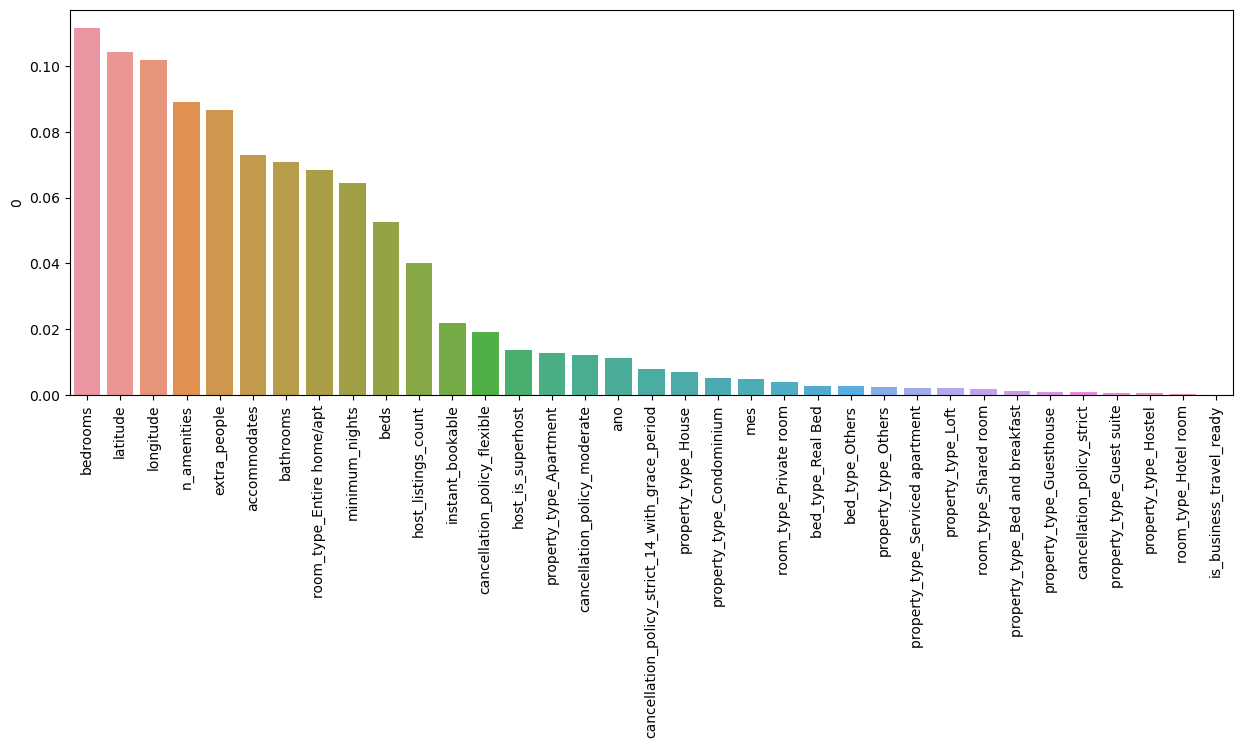

In [52]:
#Verificando a importância das features do modelo:

importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

Ajustes Finais no Modelo:

- is_business_travel_ready não parece ter muito impacto para o modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [53]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:97.50%
RSME:41.91


In [54]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:    
        base_teste = base_teste.drop(coluna, axis=1)

y = base_teste['price']
X = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:97.49%
RSME:41.98


In [55]:
print(previsao)

[101.   990.59 249.2  ... 124.8  275.22 119.92]


Deploy do Modelo:
- Criar arquivo para o deploy do modelo

In [56]:
X['price'] = y
X.to_csv('dados-airbnb-modelo.csv')

In [60]:
import joblib
joblib.dump(modelo_et, 'modelo-et-airbnb.joblib')

['modelo-et-airbnb.joblib']